# Maximum possible efficiency of a solar thermal energy system #

By Steven J. Byrnes. Last modified: 2016-05-21. This document lives at my website, [http://sjbyrnes.com/](http://sjbyrnes.com/). Please email me any feedback: steven.byrnes@gmail.com

Here is the system I'm modeling: There's a flat panel absorbing sunlight, and it might or might not be sitting under a lens that concentrates the sunlight. The panel gets hot (thanks to the sunlight), and dumps heat into an ideal heat engine (running at the Carnot efficiency). The heat engine's waste heat goes into a heat sink at ambient temperature. We are interested in how much useful energy the heat engine generates, as a fraction of sunlight energy it absorbs.

If the panel loses heat to the environment, that's a waste, and it lowers the system's efficiency. Since I am interested in the maximum possible efficiency, I'll assume that no heat is lost to convection, conduction, etc. Unfortunately, the panel must inevitably lose energy to thermal radiation, because if it didn't radiate at all then it would be a "whitebody", and if it was a whitebody then it would not absorb any sunlight (cf. [Kirchhoff's law of thermal radiation](http://en.wikipedia.org/wiki/Kirchhoff's_law_of_thermal_radiation)). In order to absorb as much sunlight as possible, while emitting as little radiation as possible, I'll assume that the panel is a "blackbody" at short wavelength (so it can absorb sunlight) and a "whitebody" at long wavelength (so that it emits very little thermal radiation). I assume for simplicity that there's a sharp switch between blackbody and whitebody, at a wavelength called the "absorption edge", which is not known in advance. I will treat the absorption edge and the panel temperature as adjustable parameters that I can choose to maximize the output power.

(Note: You could in principle get slightly higher efficiency by having an emissivity profile that is more complicated than the form I'm assuming, i.e. a sharp edge separating blackbody and whitebody. But I doubt it makes a huge difference.)

## Direct light vs diffuse light ##

A concentrated-light system (with lenses or mirrors to focus the light on the cell) can collect only the light coming directly from the sun. The "diffuse" light coming from the rest of the sky cannot be focused, so it is wasted in a concentrated system (but it *is* used in unconcentrated systems). That diffuse light is at least ~15% of the total, up to ~100% if a cloud is blocking the sun.

<p style="font-size:80%">[Note for pedants: <a href="https://en.wikipedia.org/wiki/Luminescent_solar_concentrator">Luminescent solar concentrators</a> can "concentrate" diffuse light in a manner of speaking. But they discard some of the photon energy in the process. I believe that they cannot increase the theoretical efficiency of a thermal system of the type considered here. They do, however, mitigate the *further* loss if you use single-junction photovoltaic cells (see <a href="http://sjbyrnes.com/sq.html">Shockley-Queisser limit</a>). For more details see the paper: <a href="http://optoelectronics.eecs.berkeley.edu/ey1990sem2123.pdf">The thermodynamic limits of light concentrators</a>.]</p>

Therefore, a concentrated-light solar power system can *never* be more than ~85% efficient. That ~15% diffuse-light waste occurs before the light even reaches to the solar power system, i.e. this loss is *on top* of the losses discussed below (like the Carnot limit). For the rest of this document, I'll neglect this loss, but you should always keep it in mind. In other words, I'm calculating the power generated as a fraction of successfully-concentrated light, not as a fraction of total incident light. Multiply the efficiency numbers below by 0.85 to get the maximum possible total system efficiency for a concentrated system.

<p style="font-size:80%">[Note for pedants: Well, in theory, you could have a high-concentration system *supplemented by* an unconcentrated system that only collects the diffuse light. That would claw back some small fraction of the diffuse-light loss.]</p>

I'm using NREL's data for the solar spectrum and intensity. To keep things simple, I will use the spectrum which is appropriate for unconcentrated light ("AM1.5G"). In reality, the spectrum changes a bit if you're concentrating the light; it's less blue because the sky is blue. This is a minor shift and does not drastically change the efficiency figures calculated below (well, I don't expect that it does, but I haven't checked).


## Relevance to photovoltaics ##

A photovoltaic cell *seems* very different than a solar thermal power generator, but actually the calculation here applies to both. So a photovoltaic cell -- even a multijunction tandem solar cell in the limit of infinitely many junctions -- cannot have a higher efficiency than the one calculated here.

## How to exceed the limit ##

One thing is, a solar power system with concentration factor N has the same fundamental efficiency limit as a solar cell with no concentration but which only accepts light approaching from an angle in a narrow acceptance window with solid angle 1/N of the hemisphere. I'm using the term "concentration" loosely to refer to either of these strategies. Very narrow acceptance windows are rarely helpful in practical systems -- in particular, the system has to track the sun using either strategy.

Besides that technicality, I only know of one proposed strategy that can beat this limit: [This paper](http://dx.doi.org/10.1021/nl3034784). I believe that it's only a slight improvement (a few percentage points).

## General program setup ##

This document is written using [Jupyter notebook](http://jupyter.org/) (See also [my page on installing and starting Python](http://sjbyrnes.com/python).)

In [1]:
# requires Python 3.6
import sys
assert sys.version_info >= (3,6)

Import various python packages

In [2]:
import numpy, scipy.interpolate, scipy.integrate, pandas

The following is a special jupyter command: It defines mathematical functions like `exp` and `plot` (same as "`from pylab import *`"), and it also makes matplotlib plots display on the page:

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


One more package: A units-and-constants package I wrote: http://pypi.python.org/pypi/numericalunits

Example usage #1: `x = 5 * nu.cm` means "x equals 5 centimeters".

Example usage #2: `y = x / nu.mm` means "y is the numerical value of x in millimeters'". 

In [4]:
import numericalunits as nu

## Ambient temperature ##

Ambient temperature is 300 kelvin:

In [5]:
T_ambient = 300 * nu.K

## Incident sunlight ##

The incident light intensity and spectrum is assumed to be the NREL AM1.5G spectrum, which approximates the light coming from the sun and sky at a typical latitude on a clear day. For more information go to https://www.nrel.gov/grid/solar-resource/spectra.html (As discussed above, to get slightly more accurate numbers for concentrated systems, you should switch to the sun-only spectrum, i.e. column 3 of the downloaded file.)

In [6]:
worksheet = pandas.read_excel('https://www.nrel.gov/grid/solar-resource/assets/data/astmg173.xls')
downloaded_array = numpy.array(worksheet)

# Wavelength is in column 0, AM1.5G data is column 2
AM15 = downloaded_array[1:, [0,2]]

# The first line should be 280.0 , 4.7309E-23
# The last line should be 4000.0, 7.1043E-03
print(AM15)

[[280 4.7309e-23]
 [280.5 1.2307e-21]
 [281 5.6895e-21]
 ...
 [3990 0.0073723]
 [3995 0.00721]
 [4000 0.0071043]]


Tack on the appropriate units:

In [7]:
AM15[:,0] *= nu.nm
AM15[:,1] *= nu.W * nu.m**-2 * nu.nm**-1

The NREL data spans the following spectral range:

In [8]:
wavelength_min = 280 * nu.nm
wavelength_max = 4000 * nu.nm

Interpolate to get a continuous function which I will be able to do integrals on:

In [9]:
AM15interp = scipy.interpolate.interp1d(AM15[:,0], AM15[:,1])

Here’s the plot, it looks correct:

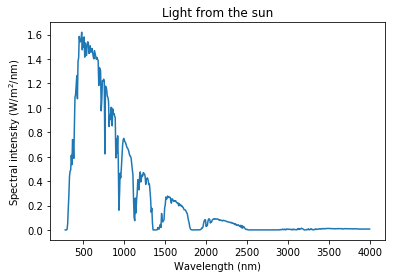

In [10]:
wavelengths = numpy.linspace(wavelength_min, wavelength_max, num=500)
y_values = numpy.array([AM15interp(x) for x in wavelengths])
plot(wavelengths / nu.nm , y_values / (nu.W / nu.m**2 / nu.nm))
xlabel("Wavelength (nm)")
ylabel("Spectral intensity (W/m$^2$/nm)")
title("Light from the sun");

The "Solar constant" is the sun's total irradiance. If I did this right, it should be 1000 watts/meter$^2$, because that's how NREL normalized their data.

In [11]:
# quad() is ordinary integration; full_output=1 is (surprisingly) how you hide
# the messages warning about poor accuracy in integrating.
solar_constant = scipy.integrate.quad(AM15interp, wavelength_min, wavelength_max, full_output=1)[0]
print(solar_constant / (nu.W/nu.m**2))

1000.7014175512563


Close enough!

Absorbed power is how much power is absorbed by the panel under unconcentrated sunlight. Remember, it only absorbs wavelengths shorter than absorption_edge.

In [12]:
def absorbed_power(absorption_edge):
    if absorption_edge > wavelength_max:
        return solar_constant
    return scipy.integrate.quad(AM15interp, wavelength_min, absorption_edge, full_output=1)[0]

Plot the absorbed power:

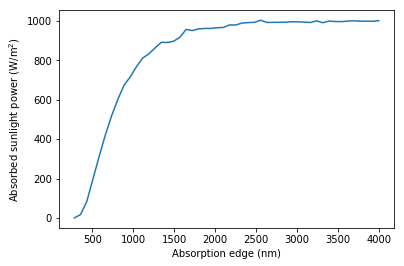

In [13]:
absorption_edge_list = linspace(wavelength_min, wavelength_max, num=50)
absorbed_power_list = array([absorbed_power(x) for x in absorption_edge_list])
plot(absorption_edge_list / nu.nm, absorbed_power_list / (nu.W / nu.m**2))
xlabel('Absorption edge (nm)')
ylabel('Absorbed sunlight power (W/m$^2$)');

It looks like ~2000nm is about right for absorbing almost all the sunlight while radiating as little as possible. But I won't commit to a specific value, I'll leave it to be optimized.

## Planck's law ##

We're assuming that the hot reservoir is a flat panel with a mirror on the bottom, that radiates into the hemisphere from the horizon to the zenith. By Planck's law:
$$\text{radiation} = 2\pi hc^2 \int_{\lambda = 0}^{\text{absorption edge}} \frac{1}{\lambda^5} \frac{1}{\exp(hc/(\lambda k_B T)) - 1} d\lambda$$
(Without the factor of $\pi$ in front, this formula would describe radiation per steradian, not total radiation into the sky hemisphere. The factor is $\pi$ because $\pi = \int_{\theta=0}^{\pi/2} \int_{\phi=0}^{2\pi} (\cos \theta) (\sin \theta \, d\theta \, d\phi)$. The $(\cos \theta)$ is included because the panel has a smaller area when you view it from an angle.)  

In [14]:
def emitted_radiation(temperature, absorption_edge):
    def integrand(lam):
        E_over_kT = nu.hPlanck * nu.c0 / (lam * nu.kB * temperature)
        # avoid overflow error
        return lam**-5 / (exp(E_over_kT) - 1) if E_over_kT < 20 else 0
    integral = scipy.integrate.quad(integrand, 50 * nu.nm, absorption_edge, full_output=1)[0]
    return 2 * pi * nu.hPlanck * nu.c0**2 * integral

I'll double-check that by comparing to the Stefan-Boltzmann law:

In [15]:
print("This ratio should equal 1:", nu.sigmaSB * (345 * nu.K)**4 / emitted_radiation(345 * nu.K, 80 * nu.um))

This ratio should equal 1: 1.0059871297038667


In [16]:
def power_generation(T_hot, absorption_edge, concentration=1):
    if T_hot <= T_ambient:
        return 0
    hot_side_absorption = absorbed_power(absorption_edge) * concentration
    hot_side_emission = emitted_radiation(T_hot, absorption_edge)
    if hot_side_emission >= hot_side_absorption:
        return 0
    hot_side_net_absorption = hot_side_absorption - hot_side_emission
    carnot_efficiency = 1 - T_ambient / T_hot
    return hot_side_net_absorption * carnot_efficiency

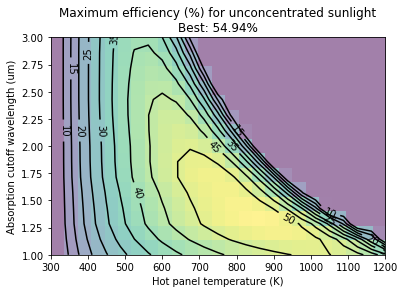

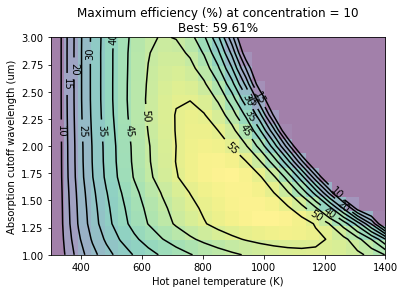

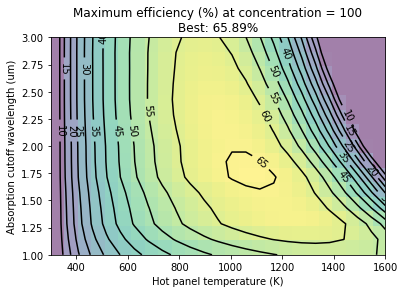

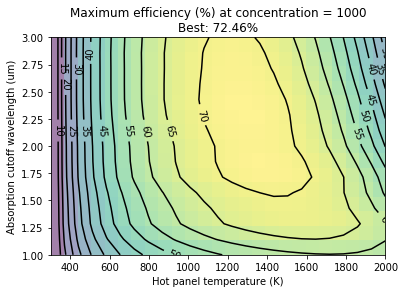

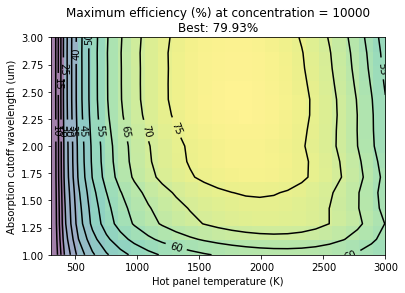

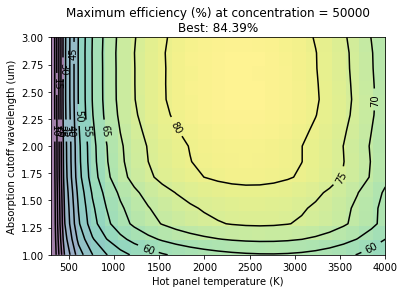

In [17]:
concentration_list = [1, 10, 100, 1000, 10000, 50000]
highest_T_to_plot_list = [x * nu.K for x in (1200, 1400, 1600, 2000, 3000, 4000)]
for i in range(6):
    concentration = concentration_list[i]
    T_list = linspace(300 * nu.K, highest_T_to_plot_list[i], num=25)
    edge_list = linspace(1 * nu.um, 3 * nu.um, num=15)
    powers = [[power_generation(T, edge, concentration) for T in T_list] for edge in edge_list]
    efficiencies = 100 * array(powers) / (concentration * solar_constant)
    max_efficiency = efficiencies.max()
    ax = figure().add_subplot(111)
    ax.imshow(efficiencies,
              extent=[T_list[0] / nu.K, T_list[-1] / nu.K,
                      edge_list[0] / nu.um, edge_list[-1] / nu.um],
              origin='lower',
              vmin=0, vmax = efficiencies.max(),
              alpha=0.5)
    contour_levels = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
    CS = ax.contour(T_list / nu.K, edge_list / nu.um,
                    efficiencies, colors='k', levels=contour_levels)
    ax.clabel(CS, inline=True, fmt='%1.0f')
    ax.set_xlabel('Hot panel temperature (K)')
    ax.set_ylabel('Absorption cutoff wavelength (um)')
    if concentration == 1:
        title_string = 'Maximum efficiency (%) for unconcentrated sunlight'
    else:
        title_string = 'Maximum efficiency (%) at concentration = ' + str(concentration)
    ax.set_title(title_string + '\n' + 'Best: {:.2f}%'.format(max_efficiency))
    ax.set_aspect('auto')